# Cancer Data Experimental ML Analysis

### INITIALIZATION

In [1]:
#import useful libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import sys
import umap
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.decomposition import KernelPCA 

In [2]:
#import data (beware, it takes like 10 minutes)
df = pd.read_csv('../clinical_TumorCompendium_v11_PolyA_2020-04-09.tsv', sep='\t', header=0)
df2 = pd.read_csv('../TumorCompendium_v11_PolyA_hugo_log2tpm_58581genes_2020-04-09.tsv', sep='\t', header=0)

FileNotFoundError: [Errno 2] No such file or directory: 'clinical_TumorCompendium_v11_PolyA_2020-04-09.tsv'

In [3]:
#define some methods
def KNN(x, y, xt, yt):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(x, y)
    return balanced_accuracy_score(yt, neigh.predict(xt))

def PCA_KNN(X_train, X_test, y_train, y_test, _k):
    pca = PCA(n_components=_k)
    pca.fit(X_train)
    X_t_train = pca.transform(X_train)
    X_t_test = pca.transform(X_test)
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_t_train, y_train)
    return balanced_accuracy_score(y_test, neigh.predict(X_t_test))

def UMAP(X_train, X_test, y_train, y_test, _k):
    mapper = umap.UMAP(n_neighbors=20).fit(X_train, y_train)
    x = mapper.transform(X_train)
    xt = mapper.transform(X_test)
    return KNN(x, y_train, xt, y_test)

def KPCA(X_train, X_test, y_train, y_test, _k):
    pca = KernelPCA(n_components=_k, kernel='poly')
    pca.fit(X_train)
    x = pca.transform(X_train)
    xt = pca.transform(X_test)
    return KNN(x, y_train, xt, y_test)

In [54]:
#experiment method for visualizing performance for PCA, KPCA, and UMAP
def run_experiment_print(pos_samples, neg_samples):
    
    x = pd.concat([pos_samples.T, neg_samples.T]) #add together all postiive and negative labels 
    x = StandardScaler().fit_transform(x) #standardize values in x (z-score standardization)

    target_zeros = pd.DataFrame(np.zeros((len(neg_samples.T), 1))) #get number of target zeros
    target_ones = pd.DataFrame(np.ones((len(pos_samples.T), 1))) #get number of target ones
    target = pd.concat([target_ones, target_zeros]) #concatenate target ones and zeros together
    target = target.reset_index(drop=True)

    #split the data into test and train
    X_train, X_test, y_train, y_test = train_test_split(x, target.to_numpy(), test_size=0.3, random_state=42)

    #PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x) #break down x with PCA (dimensionality reduction) into 2 components
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, target], axis = 1) #puts labels alongside PCA components (one and two)

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(2,2,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [1.0, 0.0]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf[0] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    plt.show()

    #KPCA
    pca = KernelPCA(n_components=2, kernel='poly')
    principalComponents = pca.fit_transform(x)
    principalDfk = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    target = pd.concat([target_ones, target_zeros])
    target = target.reset_index(drop=True)
    finalDfk = pd.concat([principalDfk, target], axis = 1)

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(2,2,2) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component KPCA', fontsize = 20)
    ax.set_ylim(-0.2,0.0)
    ax.set_xlim(-0.5,0.5)
    targets = [1.0, 0.0]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDfk[0] == target
        ax.scatter(finalDfk.loc[indicesToKeep, 'principal component 1']
                   , finalDfk.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    plt.show()

    #UMAP
    target = pd.concat([target_ones, target_zeros])
    target = target.reset_index(drop=True)
    mapper = umap.UMAP(n_neighbors=20).fit(x, target.to_numpy())
    y = mapper.transform(x)
    principalDfu = pd.DataFrame(data = y
                 , columns = ['principal component 1', 'principal component 2'])

    finalDfu = pd.concat([principalDfu, target], axis = 1)

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(2,2,3) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component UMAP', fontsize = 20)
    targets = [1.0, 0.0]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDfu[0] == target
        ax.scatter(finalDfu.loc[indicesToKeep, 'principal component 1']
                   , finalDfu.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    plt.show()
    
    return

### Dataset Visualization

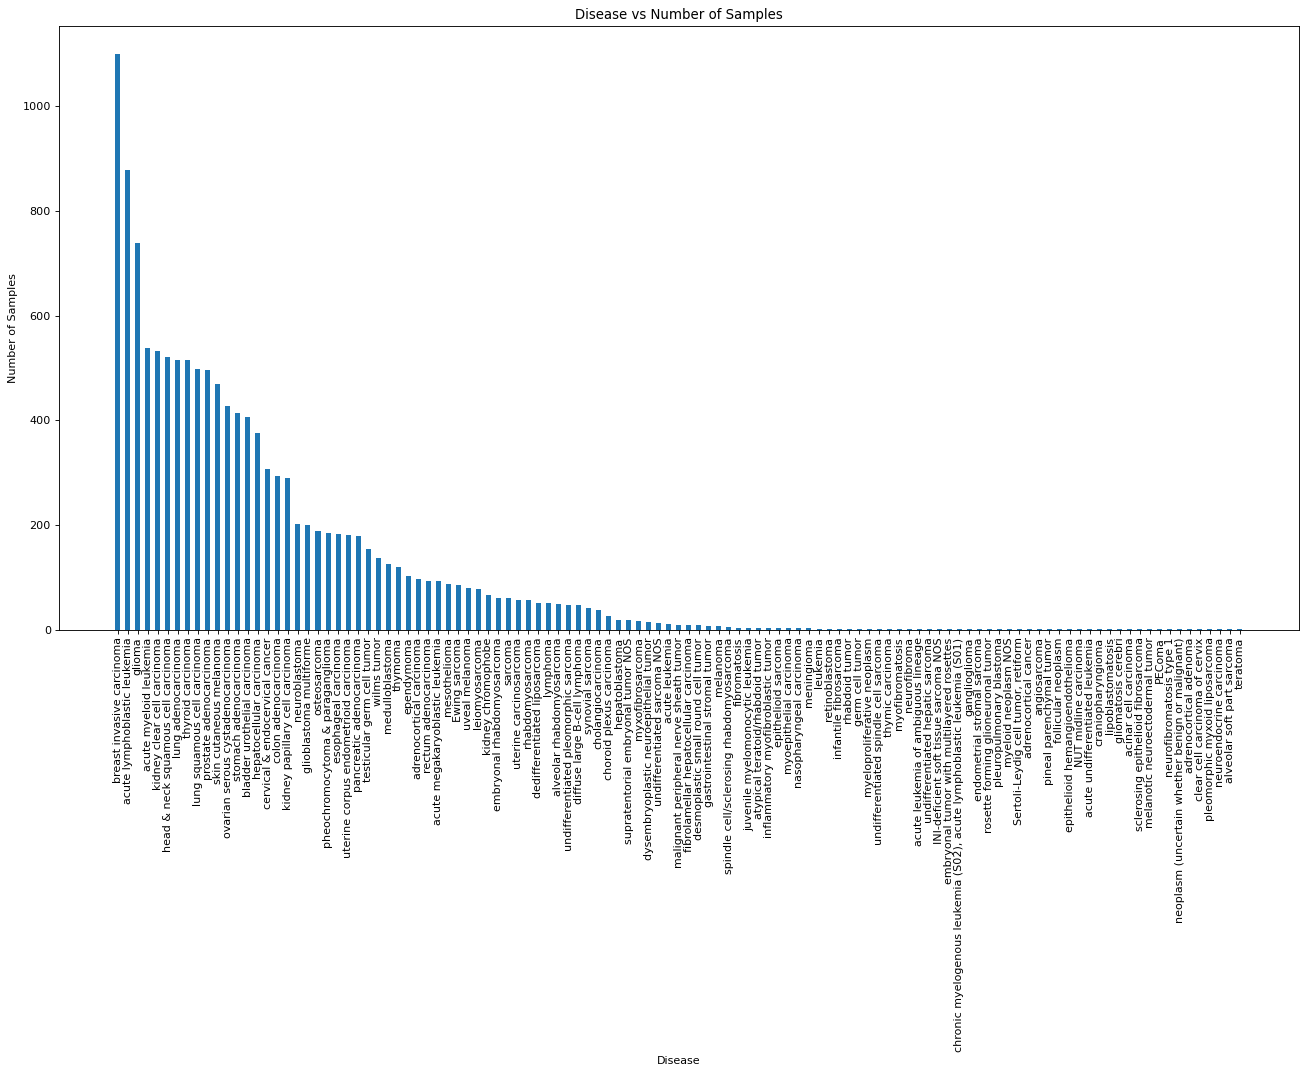

In [62]:
item_counts = df['disease'].value_counts()

X = list(item_counts.index)
Ygirls = list(item_counts.values)
  
X_axis = np.arange(len(X))
figure(figsize=(20, 10), dpi=80)
  
plt.bar(X_axis, Ygirls, 0.5)
  
plt.xticks(X_axis, X)
plt.xticks(rotation=90)
plt.xlabel("Disease")
plt.ylabel("Number of Samples")
plt.title("Disease vs Number of Samples")
plt.show()

In [63]:
diseases = list(df['disease'].unique())

### Experiments with corresponding data visualization at top of experiment sequence

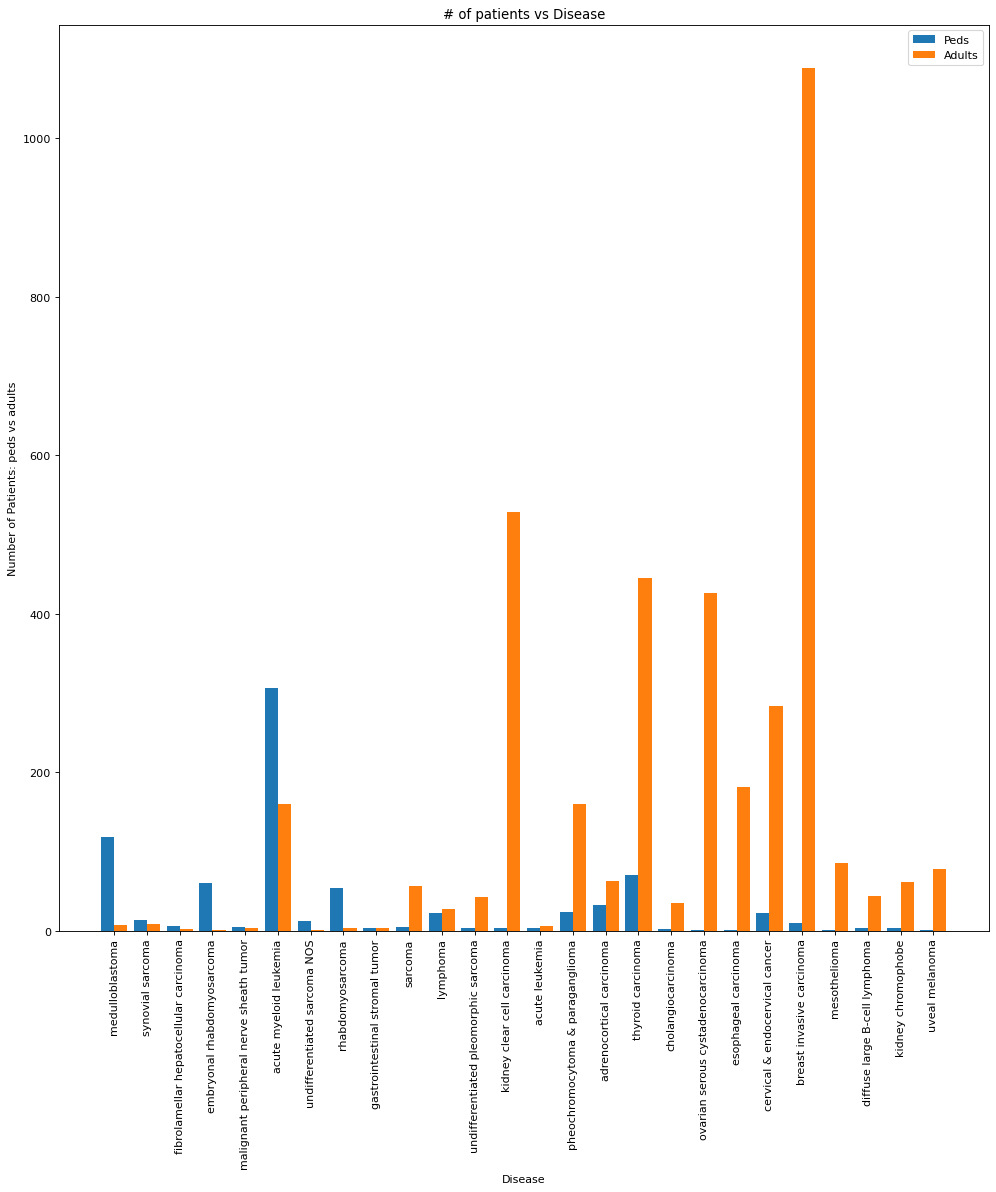

In [94]:
#collects data for number of patients vs disease (separated by ped vs adult)
yes = []
no = []
dis_name = []
for x in diseases:
    df_samples = df[df['disease']==x]
    peds_val = list(df_samples['pedaya'].dropna().unique())
    peds = df_samples['pedaya'].value_counts()
    if(len(peds_val)==2 and ('Unknown' not in peds_val)):
        yes.append(peds['Yes, age < 30 years'])
        no.append(peds['No'])
        dis_name.append(x)  
        
#plots data for number of patients vs disease (separated by ped vs adult)
X = dis_name
Ygirls = yes
Zboys = no
  
X_axis = np.arange(len(X))
figure(figsize=(15, 15), dpi=80)
  
plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Peds')
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Adults')
  
plt.xticks(X_axis, X)
plt.xticks(rotation=90)
plt.xlabel("Disease")
plt.ylabel("Number of Patients: peds vs adults")
plt.title("# of patients vs Disease")
plt.legend()
plt.show()

### ACUTE MYELOID LEUKEMIA: ped v. non-ped

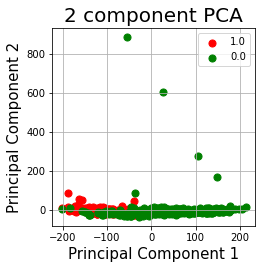

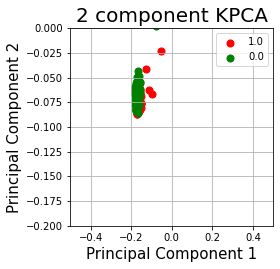

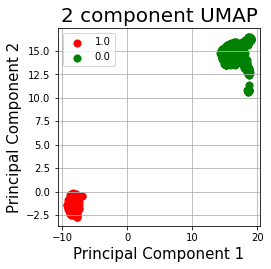

In [55]:
df_samples = df[df['disease']=='acute myeloid leukemia']

samples = df_samples[df_samples['pedaya']=='No']['th_sampleid']
pos_samples = df2.loc[:,list(samples)]

samples = df_samples[df_samples['pedaya']=='Yes, age < 30 years']['th_sampleid']
neg_samples = df2.loc[:,list(samples)]

run_experiment_print(pos_samples, neg_samples)

### ADRENOCORTICAL CARCINOMA: ped v. non-ped

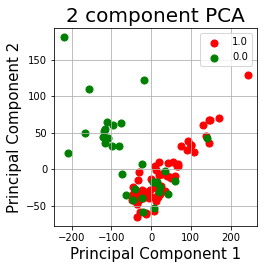

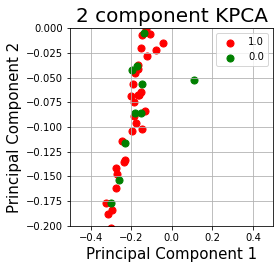

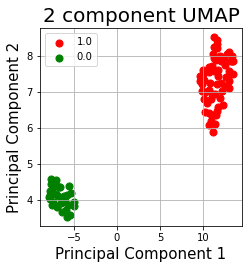

In [67]:
df_samples = df[df['disease']=='adrenocortical carcinoma']

samples = df_samples[df_samples['pedaya']=='No']['th_sampleid']
pos_samples = df2.loc[:,list(samples)]

samples = df_samples[df_samples['pedaya']=='Yes, age < 30 years']['th_sampleid']
neg_samples = df2.loc[:,list(samples)]

run_experiment_print(pos_samples, neg_samples)

### LYMPHOMA: ped v. non-ped

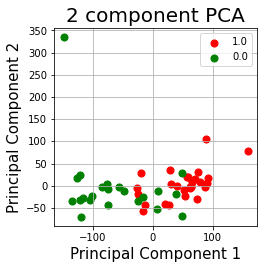

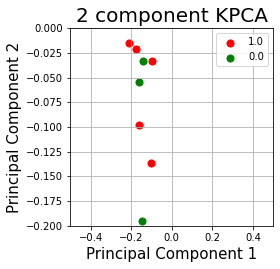

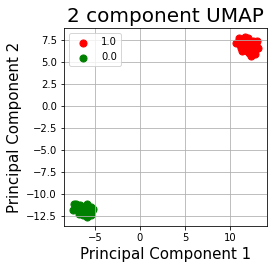

In [74]:
df_samples = df[df['disease']=='lymphoma']

samples = df_samples[df_samples['pedaya']=='No']['th_sampleid']
pos_samples = df2.loc[:,list(samples)]

samples = df_samples[df_samples['pedaya']=='Yes, age < 30 years']['th_sampleid']
neg_samples = df2.loc[:,list(samples)]

run_experiment_print(pos_samples, neg_samples)

### PHEOCHROMOCYTOMA & PARAGANGLIOMA: ped v. non-ped

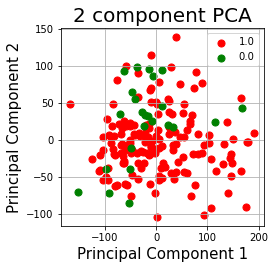

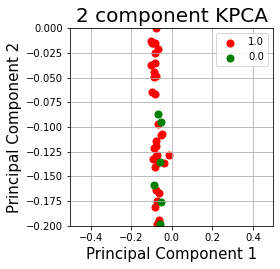

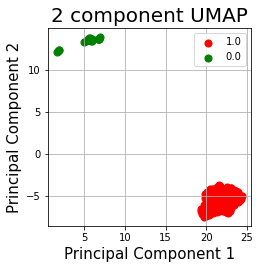

In [75]:
df_samples = df[df['disease']=='pheochromocytoma & paraganglioma']

samples = df_samples[df_samples['pedaya']=='No']['th_sampleid']
pos_samples = df2.loc[:,list(samples)]

samples = df_samples[df_samples['pedaya']=='Yes, age < 30 years']['th_sampleid']
neg_samples = df2.loc[:,list(samples)]

run_experiment_print(pos_samples, neg_samples)

### THYROID CARCINOMA: ped v. non-ped (*** maybe could be used)

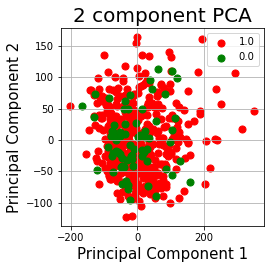

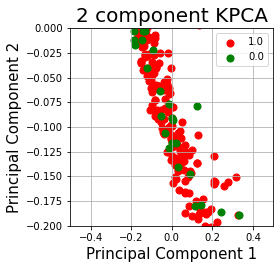

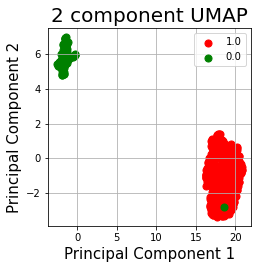

In [76]:
df_samples = df[df['disease']=='thyroid carcinoma']

samples = df_samples[df_samples['pedaya']=='No']['th_sampleid']
pos_samples = df2.loc[:,list(samples)]

samples = df_samples[df_samples['pedaya']=='Yes, age < 30 years']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

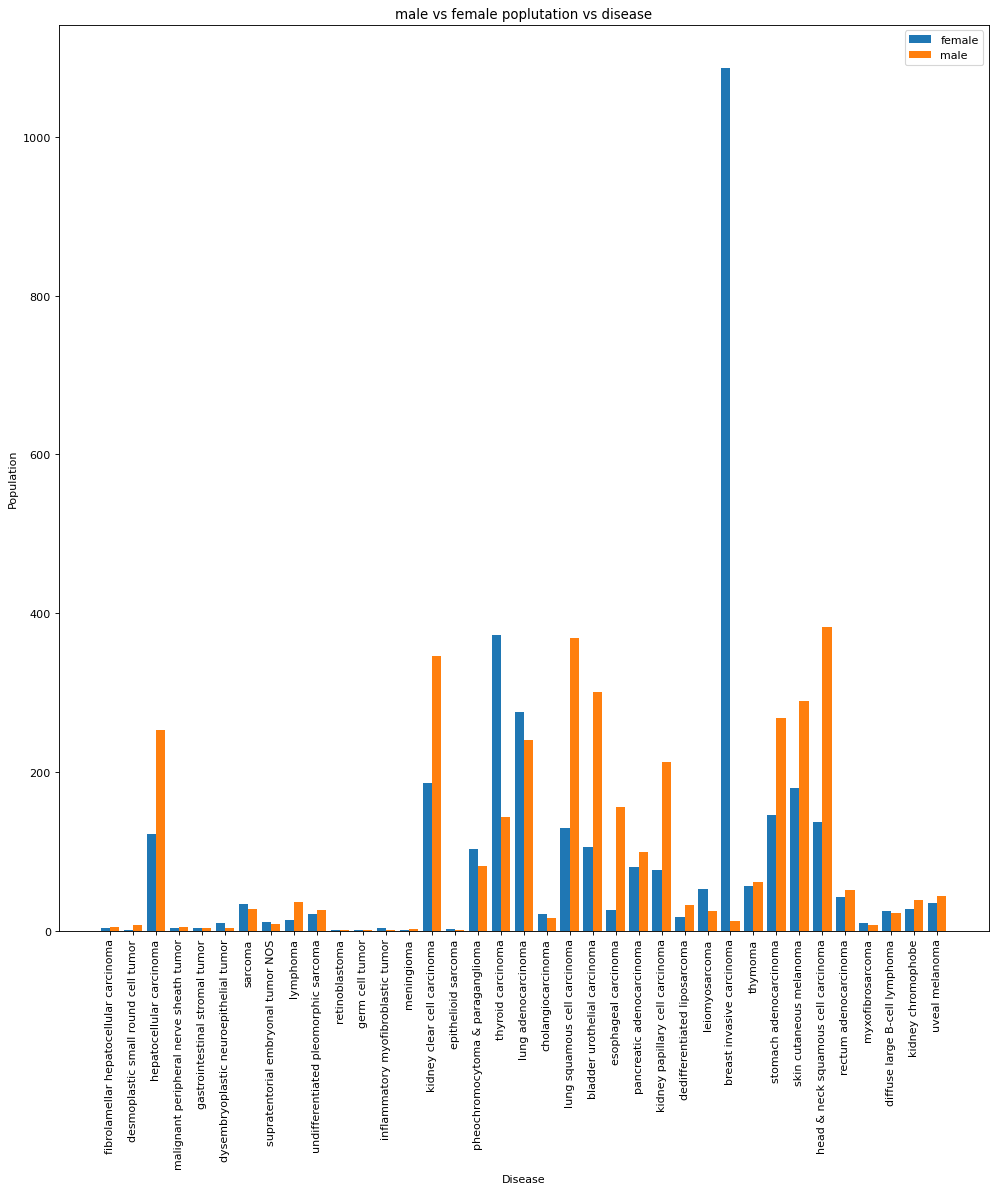

In [93]:
#collects data for number of patients vs disease (separated by male and female)
male = []
female = []
dis_name2 = []
for x in diseases:
    df_samples = df[df['disease']==x]
    peds_val = list(df_samples['gender'].dropna().unique())
    peds = df_samples['gender'].value_counts()
    if(len(peds_val)==2 and ('male' in peds_val) and ('female' in peds_val)):
        male.append(peds['male'])
        female.append(peds['female'])
        dis_name2.append(x)
        
#data for number of patients vs disease (separated by male and female)
X = dis_name2
Ygirls = female
Zboys = male
  
X_axis = np.arange(len(X))
figure(figsize=(15, 15), dpi=80)
  
plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'female')
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'male')
  
plt.xticks(X_axis, X)
plt.xticks(rotation=90)
plt.xlabel("Disease")
plt.ylabel("Population")
plt.title("male vs female poplutation vs disease")
plt.legend()
plt.show()

### THYROID CARCINOMA: male v. female

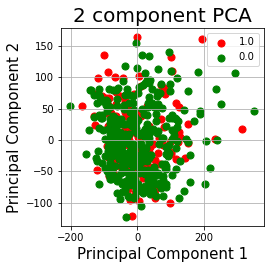

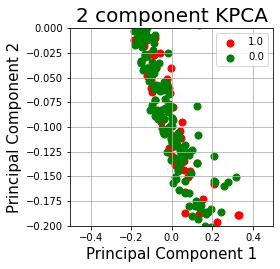

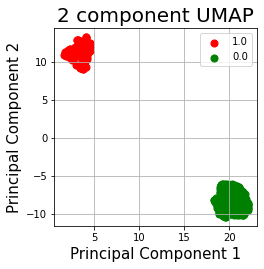

In [77]:
df_samples = df[df['disease']=='thyroid carcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid']
pos_samples = df2.loc[:,list(samples)]

samples = df_samples[df_samples['gender']=='female']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### HEPATOCELLULAR CARCINOMA: male v. female (*** maybe could be used)

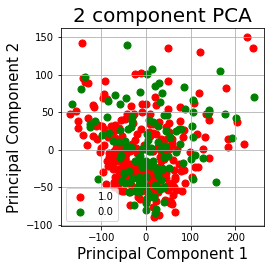

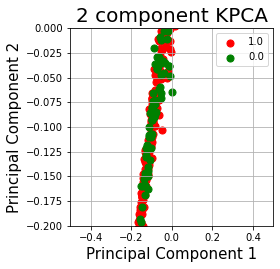

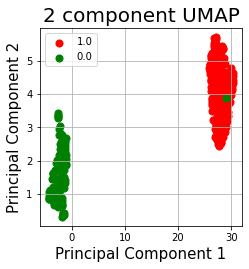

In [78]:
df_samples = df[df['disease']=='hepatocellular carcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid']
pos_samples = df2.loc[:,list(samples)]

samples = df_samples[df_samples['gender']=='female']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### KIDNEY CLEAR CELL CARCINOMA: male v. female

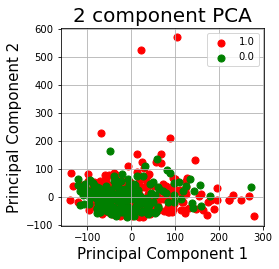

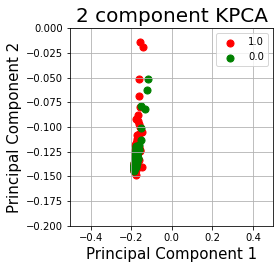

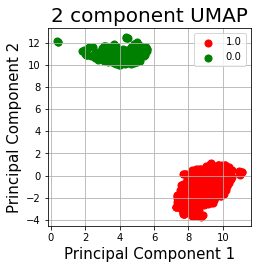

In [79]:
df_samples = df[df['disease']=='kidney clear cell carcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)]

samples = df_samples[df_samples['gender']=='female']['th_sampleid']
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### PHEOCHROMOCYTOMA & PARAGANGLIOMA: male v. female

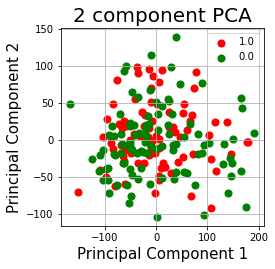

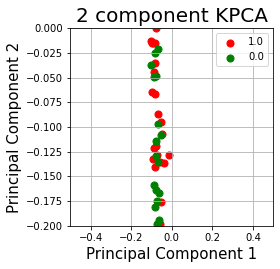

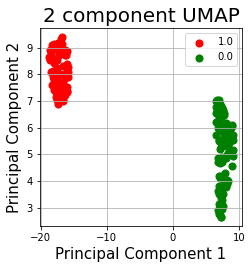

In [80]:
df_samples = df[df['disease']=='pheochromocytoma & paraganglioma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df_samples[df_samples['gender']=='female']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)]

run_experiment_print(pos_samples, neg_samples)

### THYROID CARCINOMA: male v. female

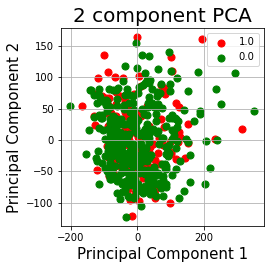

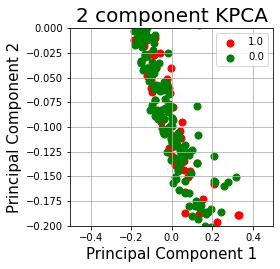

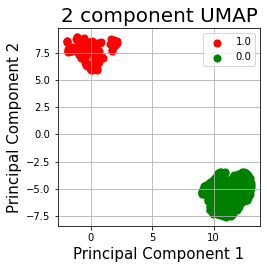

In [81]:
df_samples = df[df['disease']=='thyroid carcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid']
pos_samples = df2.loc[:,list(samples)] 

samples = df_samples[df_samples['gender']=='female']['th_sampleid']
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### LUNG ADENOCARCINOMA: male v. female

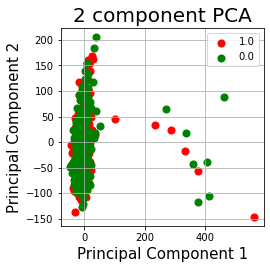

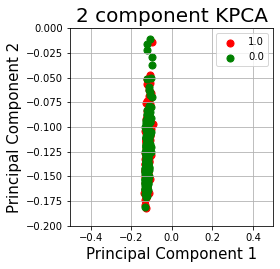

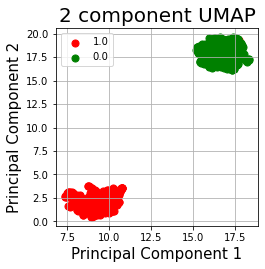

In [82]:
df_samples = df[df['disease']=='lung adenocarcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df_samples[df_samples['gender']=='female']['th_sampleid']
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### CHOLANGIOCARCINOMA: male v. female

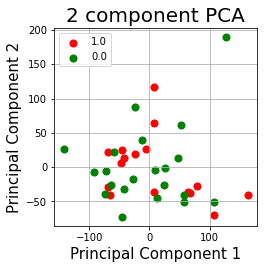

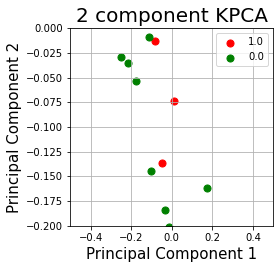

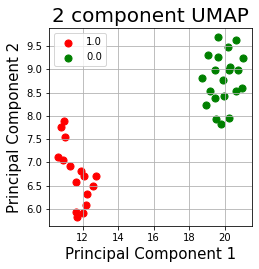

In [83]:
df_samples = df[df['disease']=='cholangiocarcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df_samples[df_samples['gender']=='female']['th_sampleid']
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### LUNG SQUAMOUS CELL CARCINOMA: male v. female (*** could maybe be used)

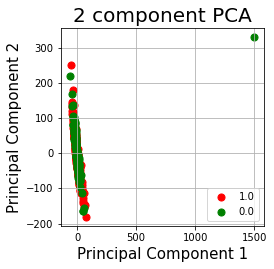

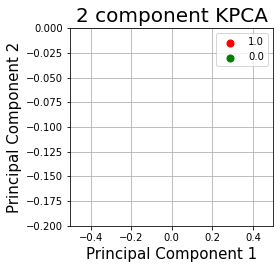

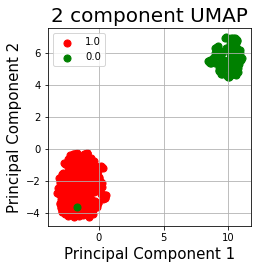

In [84]:
df_samples = df[df['disease']=='lung squamous cell carcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid']
pos_samples = df2.loc[:,list(samples)] 

samples = df_samples[df_samples['gender']=='female']['th_sampleid']
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### BLADDER UROTHELIAL CARCINOMA: male v. female

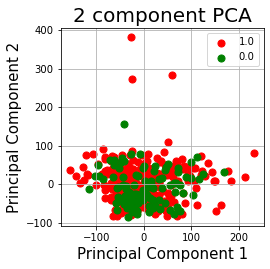

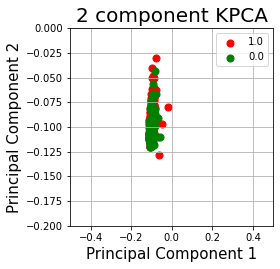

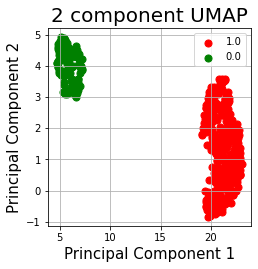

In [85]:
df_samples = df[df['disease']=='bladder urothelial carcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid']
pos_samples = df2.loc[:,list(samples)] 

samples = df_samples[df_samples['gender']=='female']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)]

run_experiment_print(pos_samples, neg_samples)

### PANCREATIC ADENOCARCINOMA: male v. female

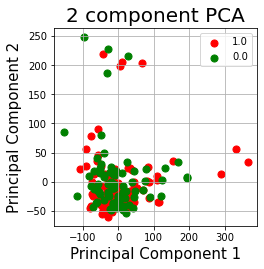

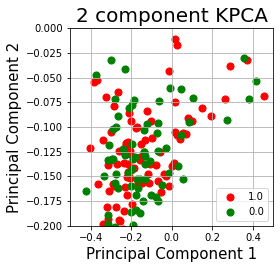

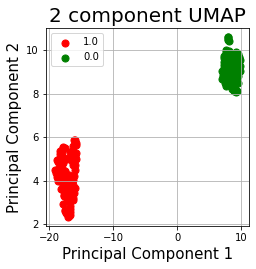

In [86]:
df_samples = df[df['disease']=='pancreatic adenocarcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)]

samples = df_samples[df_samples['gender']=='female']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### KIDNEY PAPILLARY CELL CARCINOMA: male v. female

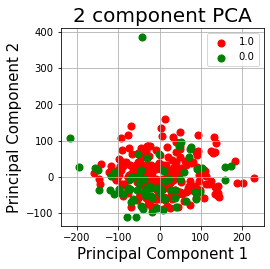

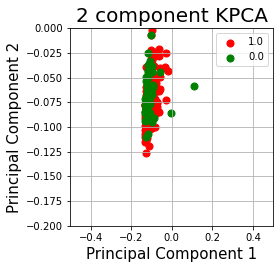

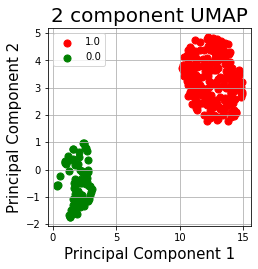

In [87]:
df_samples = df[df['disease']=='kidney papillary cell carcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df_samples[df_samples['gender']=='female']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### THYMOMA: male v. female

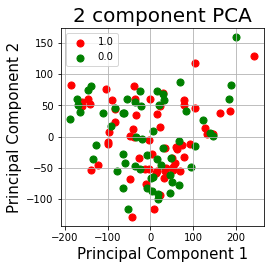

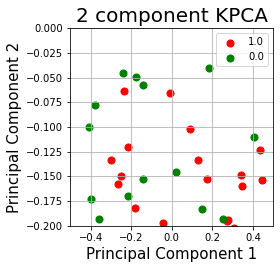

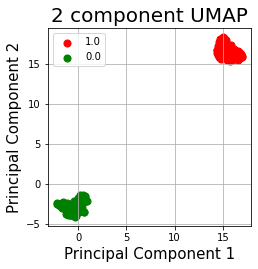

In [88]:
df_samples = df[df['disease']=='thymoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)]

samples = df_samples[df_samples['gender']=='female']['th_sampleid']
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### STOMACH ADENOCARCINOMA: male v. female

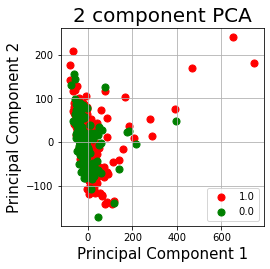

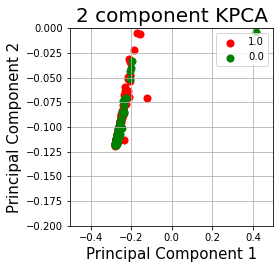

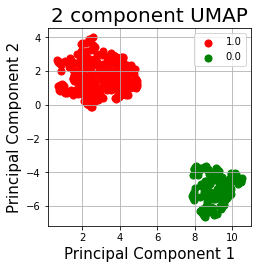

In [89]:
df_samples = df[df['disease']=='stomach adenocarcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df_samples[df_samples['gender']=='female']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### SKIN CUTANEOUS MELANOMA: male v. female

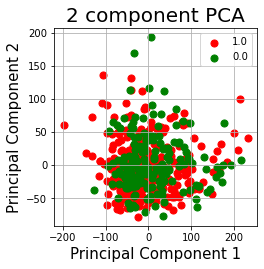

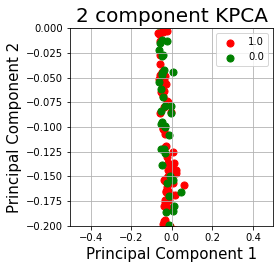

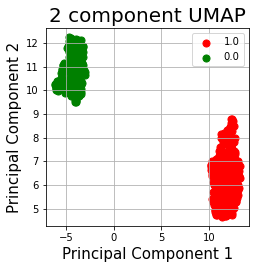

In [90]:
df_samples = df[df['disease']=='skin cutaneous melanoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df_samples[df_samples['gender']=='female']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)]

run_experiment_print(pos_samples, neg_samples)

### HEAD & NECK SQUAMOUS CELL CARCINOMA: male v. female

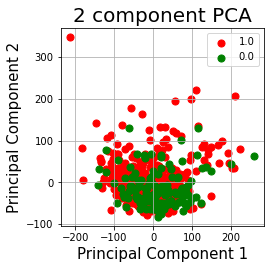

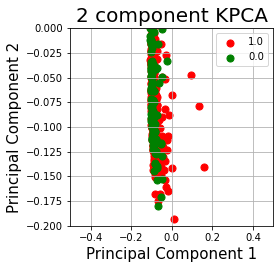

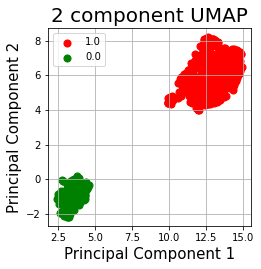

In [91]:
df_samples = df[df['disease']=='head & neck squamous cell carcinoma']

samples = df_samples[df_samples['gender']=='male']['th_sampleid']
pos_samples = df2.loc[:,list(samples)] 

samples = df_samples[df_samples['gender']=='female']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

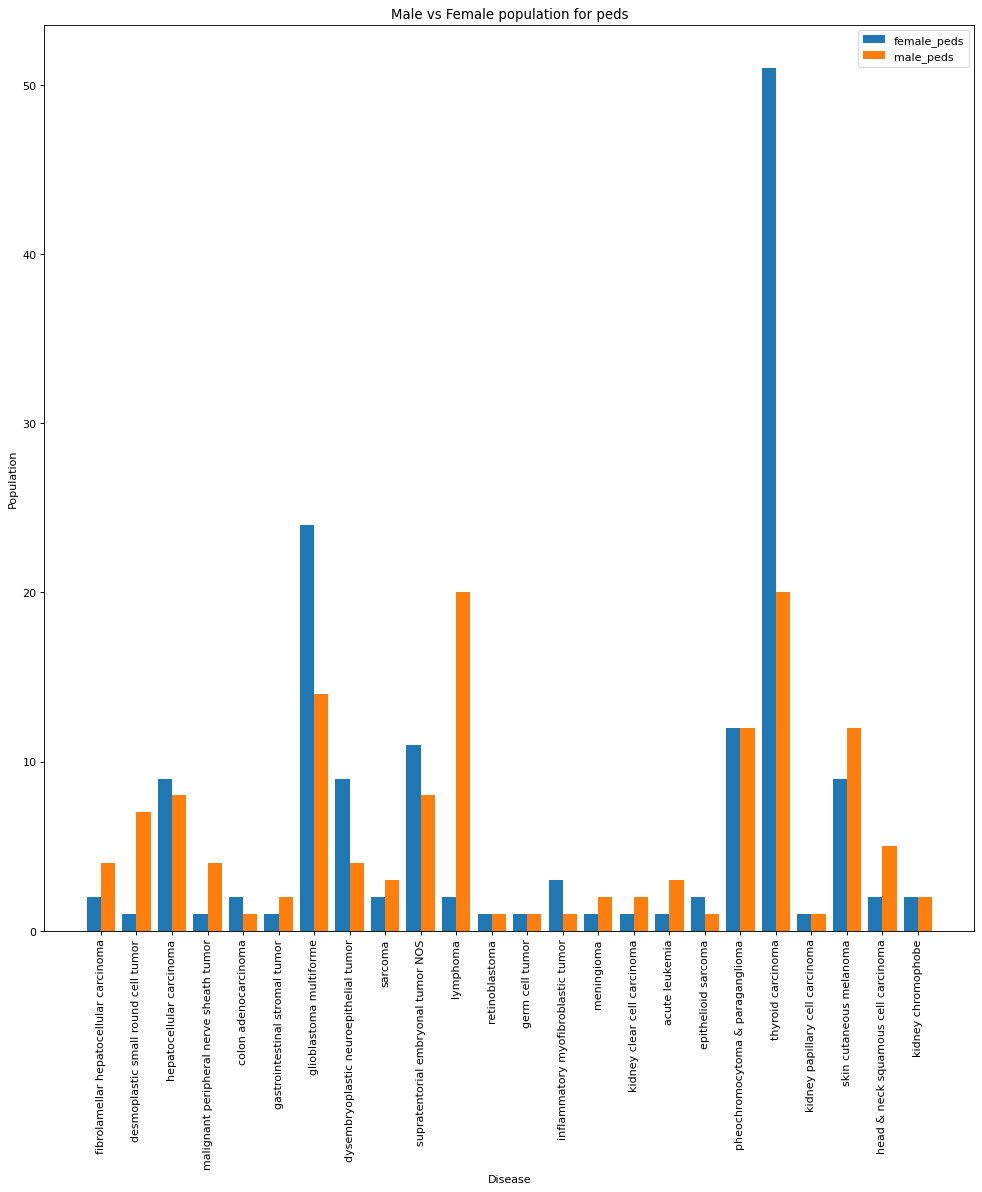

In [92]:
#collects data for number of ped patients vs disease (separated by male and female)
male_peds = []
female_peds = []
dis_name3 = []
for x in diseases:
    df_samples = df[(df['disease']==x)&(df['pedaya'] == 'Yes, age < 30 years')]
    peds_val = list(df_samples['gender'].dropna().unique())
    peds = df_samples['gender'].value_counts()
    if(len(peds_val)==2 and ('male' in peds_val) and ('female' in peds_val)):
        male_peds.append(peds['male'])
        female_peds.append(peds['female'])
        dis_name3.append(x)
        
#plots data for number of ped patients vs disease (separated by male and female)
X = dis_name3
Ygirls = female_peds
Zboys = male_peds
  
X_axis = np.arange(len(X))
figure(figsize=(15, 15), dpi=80)
  
plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'female_peds')
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'male_peds')
  
plt.xticks(X_axis, X)
plt.xticks(rotation=90)
plt.xlabel("Disease")
plt.ylabel("Population")
plt.title("Male vs Female population for peds")
plt.legend()
plt.show()

### THYROID CARCINOMA: male v. female (PEDS)

<ipython-input-56-db79d879739f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  samples = df_samples[df['gender']=='male']['th_sampleid']


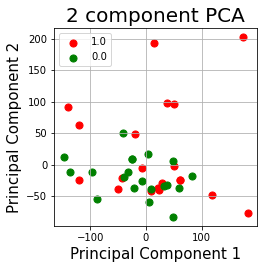

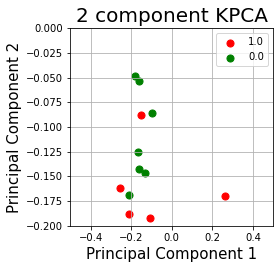

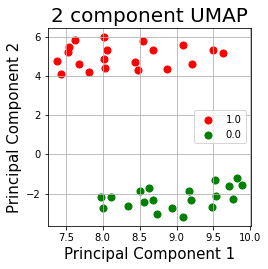

In [56]:
df_samples = df[(df['disease']=='thyroid carcinoma')&(df['pedaya'] == 'Yes, age < 30 years')]
samples = df_samples[df['gender']=='male']['th_sampleid']
pos_samples = df2.loc[:,list(samples)]
all_samples = list(df2.columns)
neg_sample_list = [ x for x in df_samples['th_sampleid'] if x not in list(samples)]
neg_samples = df2.loc[:, random.sample(neg_sample_list, len(samples))]

run_experiment_print(pos_samples, neg_samples)

### GLIOBLASTOMA MULTIFORME: male v. female (PEDS)

<ipython-input-68-008b5dfaf5ff>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  samples = df_samples[df['gender']=='male']['th_sampleid']


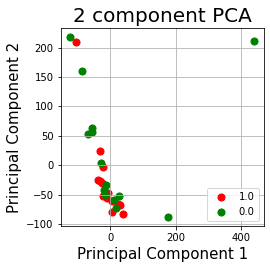

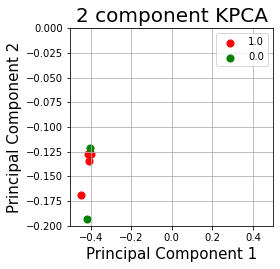

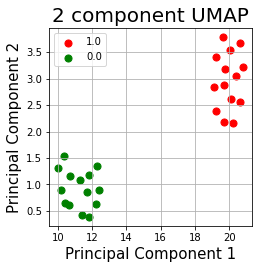

In [68]:
df_samples = df[(df['disease']=='glioblastoma multiforme')&(df['pedaya'] == 'Yes, age < 30 years')]
samples = df_samples[df['gender']=='male']['th_sampleid']
pos_samples = df2.loc[:,list(samples)]
all_samples = list(df2.columns)
neg_sample_list = [ x for x in df_samples['th_sampleid'] if x not in list(samples)]
neg_samples = df2.loc[:, random.sample(neg_sample_list, len(samples))]

run_experiment_print(pos_samples, neg_samples)

### PHEOCHROMOCYTOMA & PARAGANGLIOMA: male v. female (PEDS)

<ipython-input-71-3c4b2fdc256a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  samples = df_samples[df['gender']=='male']['th_sampleid']


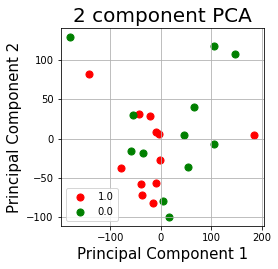

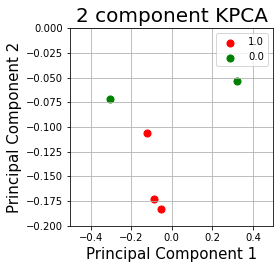

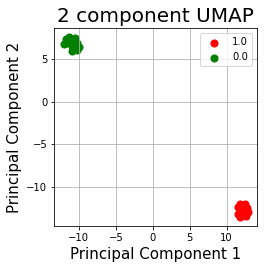

In [71]:
df_samples = df[(df['disease']=='pheochromocytoma & paraganglioma')&(df['pedaya'] == 'Yes, age < 30 years')]
samples = df_samples[df['gender']=='male']['th_sampleid']
pos_samples = df2.loc[:,list(samples)]
all_samples = list(df2.columns)
neg_sample_list = [ x for x in df_samples['th_sampleid'] if x not in list(samples)]
neg_samples = df2.loc[:, random.sample(neg_sample_list, len(samples))]

run_experiment_print(pos_samples, neg_samples)

### SUPRATENTORIAL EMBRYONAL TUMOR NOS: male v. female (PEDS)

<ipython-input-72-1dfa2f25d563>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  samples = df_samples[df['gender']=='male']['th_sampleid']


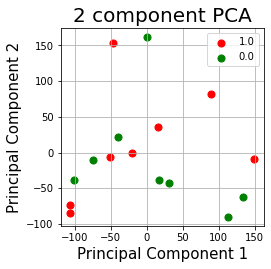

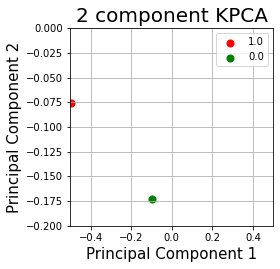

C:\Users\richi_afzmjq6\anaconda3\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


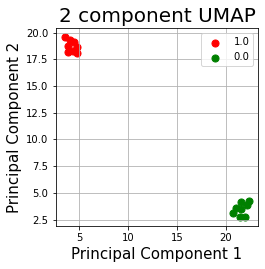

In [72]:
df_samples = df[(df['disease']=='supratentorial embryonal tumor NOS')&(df['pedaya'] == 'Yes, age < 30 years')]
samples = df_samples[df['gender']=='male']['th_sampleid']
pos_samples = df2.loc[:,list(samples)]
all_samples = list(df2.columns)
neg_sample_list = [ x for x in df_samples['th_sampleid'] if x not in list(samples)]
neg_samples = df2.loc[:, random.sample(neg_sample_list, len(samples))]

run_experiment_print(pos_samples, neg_samples)

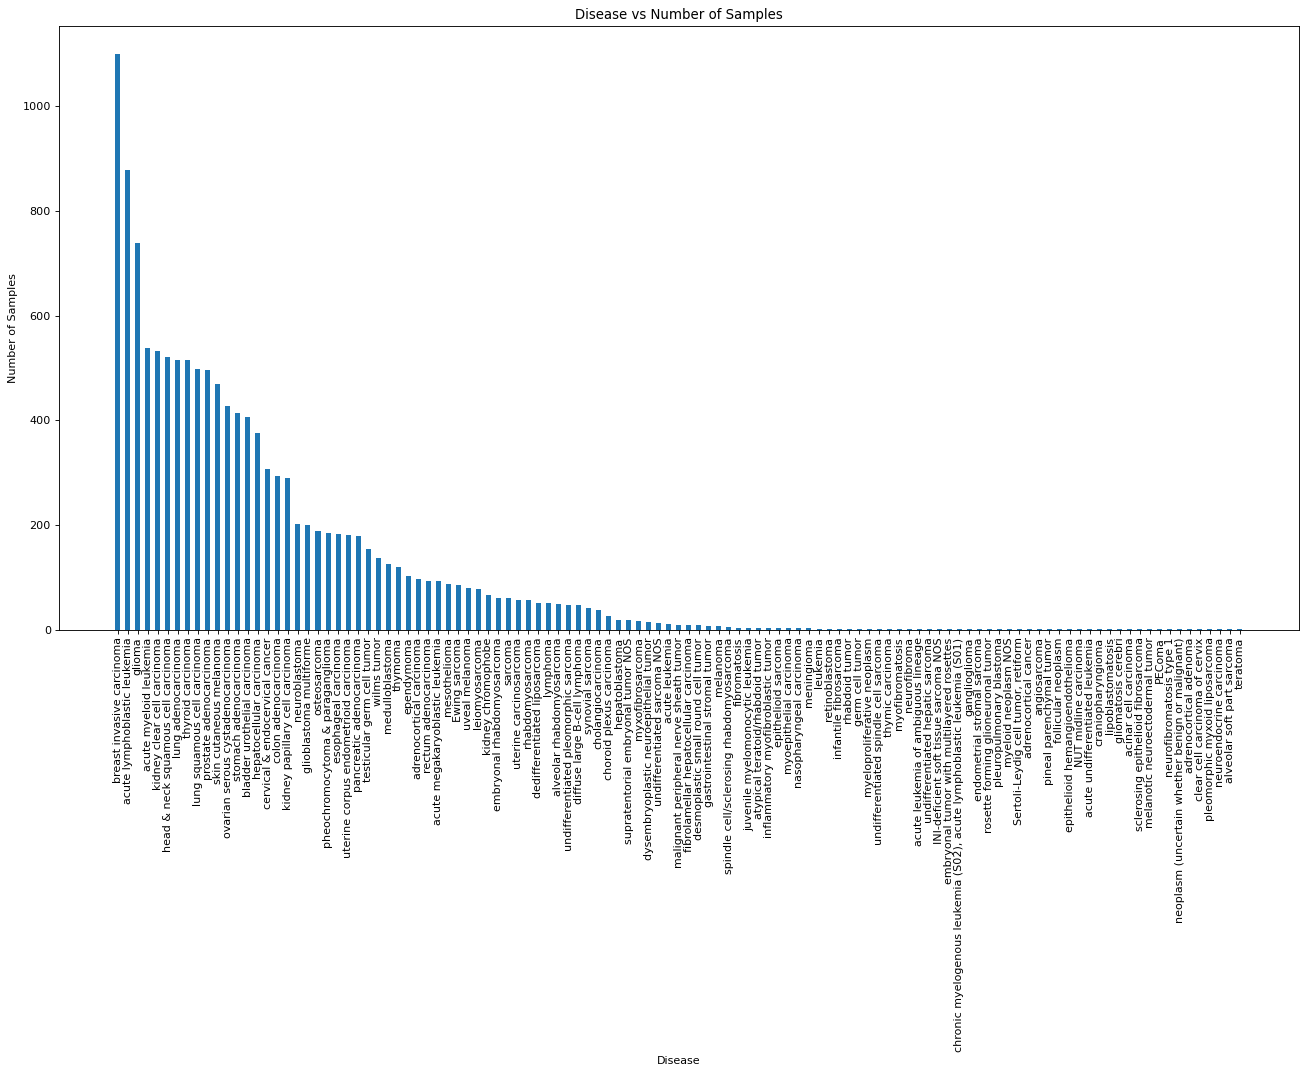

In [97]:
#plot again
item_counts = df['disease'].value_counts()

X = list(item_counts.index)
Ygirls = list(item_counts.values)
  
X_axis = np.arange(len(X))
figure(figsize=(20, 10), dpi=80)
  
plt.bar(X_axis, Ygirls, 0.5)
  
plt.xticks(X_axis, X)
plt.xticks(rotation=90)
plt.xlabel("Disease")
plt.ylabel("Number of Samples")
plt.title("Disease vs Number of Samples")
plt.show()

In [100]:
diseases = list(df['disease'].unique())
item_counts = df['disease'].value_counts()
item_counts[0:40]

breast invasive carcinoma                1099
acute lymphoblastic leukemia              878
glioma                                    738
acute myeloid leukemia                    538
kidney clear cell carcinoma               532
head & neck squamous cell carcinoma       520
lung adenocarcinoma                       516
thyroid carcinoma                         516
lung squamous cell carcinoma              498
prostate adenocarcinoma                   496
skin cutaneous melanoma                   469
ovarian serous cystadenocarcinoma         427
stomach adenocarcinoma                    414
bladder urothelial carcinoma              407
hepatocellular carcinoma                  375
cervical & endocervical cancer            306
colon adenocarcinoma                      293
kidney papillary cell carcinoma           289
neuroblastoma                             201
glioblastoma multiforme                   200
osteosarcoma                              189
pheochromocytoma & paraganglioma  

### KIDNEY CLEAR CELL CARCINOMA v. KIDNEY PAPILLARY CELL CARCINOMA

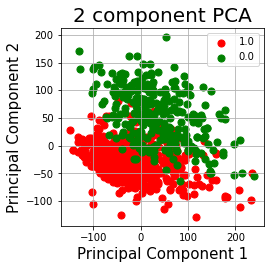

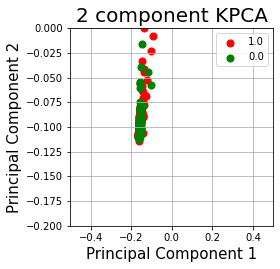

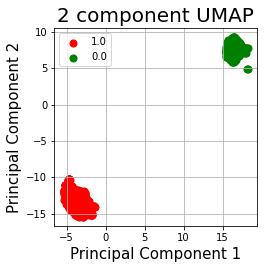

In [96]:
samples = df[df['disease']=='kidney clear cell carcinoma']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df[df['disease']=='kidney papillary cell carcinoma']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)]

run_experiment_print(pos_samples, neg_samples)

### ACUTE LYMPHOBLASTIC LEUKEMIA v. ACUTE MYELOID LEUKEMIA (*** could maybe be used)

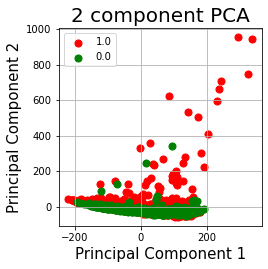

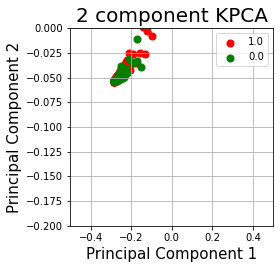

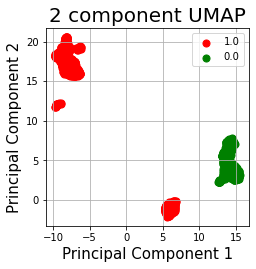

In [101]:
samples = df[df['disease']=='acute lymphoblastic leukemia']['th_sampleid']
pos_samples = df2.loc[:,list(samples)] 

samples = df[df['disease']=='acute myeloid leukemia']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### LUNG ADENOCARCINOMA v. LUNG SQUAMOUS CELL CARCINOMA (*** could maybe be used)

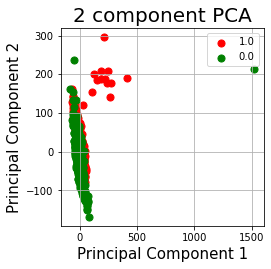

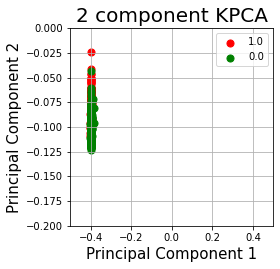

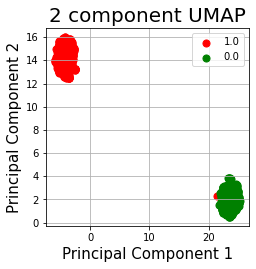

In [102]:
samples = df[df['disease']=='lung adenocarcinoma']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df[df['disease']=='lung squamous cell carcinoma']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### CERVICAL & ENDOCERVICAL CANCER v. OVARIAN SEROUS CYSTADENOCARCINOMA

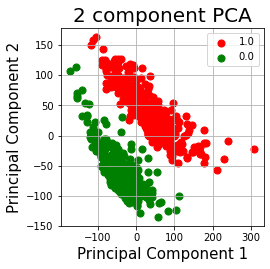

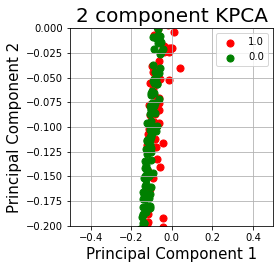

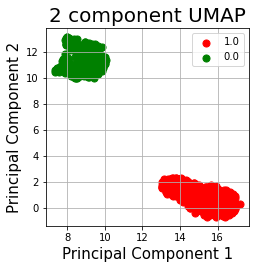

In [104]:
samples = df[df['disease']=='ovarian serous cystadenocarcinoma']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df[df['disease']=='cervical & endocervical cancer']['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### NEUROBLASTOMA v. MEDULLOBLASTOMA (*** could maybe be used)

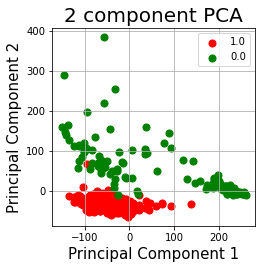

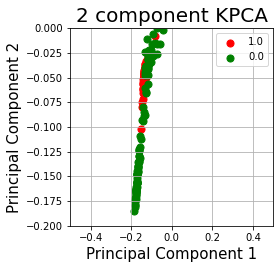

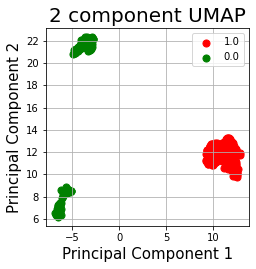

In [105]:
samples = df[df['disease']=='neuroblastoma']['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df[df['disease']=='medulloblastoma']['th_sampleid']
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### The following experiments combine more than one cancer type into a particular classification

### (GLIOMA, LUNG ADENOCARCINOMA, ACUTE LYMPHOBLASTIC LEUKEMIA) v. (THYROID CARCINOMA, LUNG SQUAMOUS CELL CARCINOMA, ACUTE MYLOID LEUKEMIA) (*** could maybe be used)

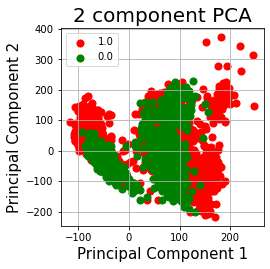

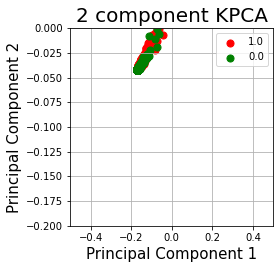

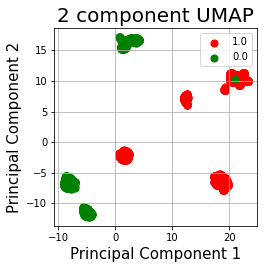

In [107]:
samples = df[(df['disease']=='lung adenocarcinoma') | (df['disease']=='acute lymphoblastic leukemia') | (df['disease']=='glioma')]['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df[(df['disease']=='thyroid carcinoma') | (df['disease']=='lung squamous cell carcinoma') | (df['disease']=='acute myeloid leukemia')]['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)

### (PANCREATIC ADENOCARCINOMA, COLON ADENOCARCINOMA) v. (PROSTATE ADENOCARCINOMA, LUNG ADENOCARCINOMA) (*** could maybe be used)

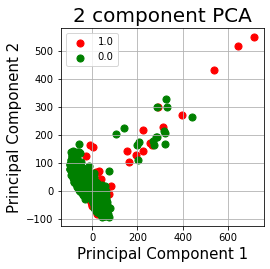

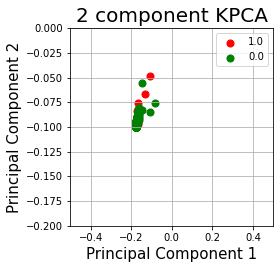

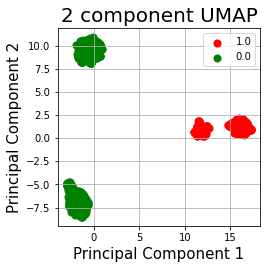

In [108]:
samples = df[(df['disease']=='pancreatic adenocarcinoma') | (df['disease']=='colon adenocarcinoma')]['th_sampleid'] 
pos_samples = df2.loc[:,list(samples)] 

samples = df[(df['disease']=='lung adenocarcinoma') | (df['disease']=='prostate adenocarcinoma')]['th_sampleid'] 
neg_samples = df2.loc[:,list(samples)] 

run_experiment_print(pos_samples, neg_samples)